# Molecular dynamics

## Introduction

The work was performed on the Linux operating system Ubuntu 22.04.3 LTS. Loaded all the necessary libraries. List of software used:

|Titile|Version|
|--|--|
|Python|3.11.6|
|Jupyter Lab|4.0.6|
|nglview|3.0.8|
|GROMACS|2018.3|
|Matplotlib|3.7.2|
|MDAnalysis|2.6.1|
|panedr|0.7.2|

<ins>Purpose of the work:</ins> to conduct the standard pipline for molecular dynamics.

Tasks:

1. Load all packages and PDB structure.
2. Create a topology file.
3. Construct triclinic box.
4. Solvate of the molecule.
5. Add K<sup>+</sup> and Cl<sup>-</sup> ions.
6. Minimize system energy.
7. Equilibrate the system twice: with and without heavy atoms fixation.
8. Conduct production run.

## Load all packages and PDB structure

In [1]:
import matplotlib.pyplot as plt
import nglview as nv
import MDAnalysis as mda
import panedr
from IPython.display import Video
import warnings
warnings.filterwarnings('ignore')

/home/snitkin/anaconda3/envs/molmodel/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


Chosen PDB structure: [**3CAP**](https://www.rcsb.org/structure/3CAP) (Bovine rhodopsin *Bos taurus*).

In [4]:
structure_id = '3CAP'

Downloaded the PDB file with the structure.

In [321]:
%%bash -s "$structure_id"
structure_id=$1
wget https://files.rcsb.org/view/$structure_id.pdb

--2023-11-27 16:10:10--  https://files.rcsb.org/view/3CAP.pdb
Распознаётся files.rcsb.org (files.rcsb.org)… 128.6.159.157
Подключение к files.rcsb.org (files.rcsb.org)|128.6.159.157|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных [text/plain]
Сохранение в: ‘3CAP.pdb.2’

     0K .......... .......... .......... .......... ..........  112K
    50K .......... .......... .......... .......... .......... 63,9K
   100K .......... .......... .......... .......... .......... 81,4K
   150K .......... .......... .......... .......... .......... 61,0K
   200K .......... .......... .......... .......... .......... 61,0K
   250K .......... .......... .......... .......... .......... 65,2K
   300K .......... .......... .......... .......... .......... 75,1K
   350K .......... .......... .......... .......... .......... 81,3K
   400K .......... .......... .......... .......... .......... 61,1K
   450K .......... .......... .......... .......... .......

Look at the model.

In [20]:
nv.show_structure_file(f'{structure_id}.pdb')

NGLWidget()

Screenshot:

![](figs/fig1.png)

I removed all non-protein parts, including retinal, and saved the protein structure in a separate file.

In [3]:
s = mda.Universe(f'{structure_id}.pdb')
structure = s.select_atoms('protein')

s.trajectory.remarks=[]
s.trajectory.compound=[]
s.trajectory.header='Protein'

structure.write(f'{structure_id}_protein.pdb')

# Look at file volumes
!ls {structure_id}*.pdb -sh

508K 3CAP.pdb
412K 3CAP_protein.pdb


In [21]:
nv.show_structure_file(f'{structure_id}_protein.pdb')

NGLWidget()

Screenshot:

![](figs/fig2.png)

## Create a topology file

* `-p <.top>` - topology file with model parameters;
* `-i <.itp>` - file that defines mobility restrictions for atoms in the structure;
* `-water spc` - water model;
* `-ff amber03` - force field;

I chose the SPC (simple point-charge) water model. In this model, a water molecule is a rigid isosceles triangle with a charge at each vertex.

Among other things, the `gmx pdb2gmx` command adds hydrogens, since they are not present in PDB files.

In [325]:
%%bash -s "$structure_id"
structure_id=$1
gmx pdb2gmx -f ${structure_id}_protein.pdb \
    -o ${structure_id}_init.pdb \
    -p ${structure_id}_topol.top \
    -i ${structure_id}_posre.itp \
    -water spc -ff amber03
ls $structure_id* -sh

                     :-) GROMACS - gmx pdb2gmx, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de


Using the Amber03 force field in directory amber03.ff

Reading 3CAP_protein.pdb...
Read 'MDANALYSIS FRAME 0: Created by PDBWriter', 5184 atoms
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 2 chains and 0 blocks of water and 652 residues with 5184 atoms

  chain  #res #atoms
  1 'A'   326   2592  
  2 'B'   326   2592  

Reading residue database... (amber03)
Processing chain 1 'A' (2592 atoms, 326 residues)
Identified residue MET1 as a starting terminus.
Identified residue ASN326 as a ending terminus.
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 326 residues with 5164 atoms
Chain time...
Processing chain 2 'B' (2592 atoms, 326 residues)
Identified residue MET1 as a starting terminus.
Identified residue ASN326 as a ending terminus.
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 326 residues with 5164 atoms
Chain t

Total charge: **-2.000 e.**

In [22]:
charge = -2

## Constructing triclinic box

I chose a triclinic shape of the box with sides 3:1:1:

`-bt triclinic -box 24 8 8 -angles 90 90 90`).

`-c` - centering a molecule in the box.

In [327]:
%%bash -s "$structure_id"
structure_id=$1
gmx editconf -bt triclinic -box 24 8 8 -angles 90 90 90 \
    -c -f ${structure_id}_init.pdb -o ${structure_id}_init_box.pdb

                     :-) GROMACS - gmx editconf, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS d

Read 10328 atoms
Volume: 5642.82 nm^3, corresponds to roughly 2539200 electrons
No velocities found
    system size :  7.745  8.772  7.552 (nm)
    center      :  1.958 -3.391 -3.289 (nm)
    box vectors : 24.292 24.292 11.042 (nm)
    box angles  :  90.00  90.00 120.00 (degrees)
    box volume  :5642.82               (nm^3)
    shift       : 10.042  7.391  7.289 (nm)
new center      : 12.000  4.000  4.000 (nm)
new box vectors : 24.000  8.000  8.000 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :1536.00               (nm^3)


I looked into the files. The box parameters have indeed changed. Since the box is cubic, all angles become equal to 90 degrees. All coordinates of the center are the same, since the molecule is centered.

In [328]:
%%bash -s "$structure_id"
structure_id=$1
head -n 3 ${structure_id}_init.pdb
head -n 3 ${structure_id}_init_box.pdb

TITLE     MDANALYSIS FRAME 0: Created by PDBWriter
REMARK    THIS IS A SIMULATION BOX
CRYST1  242.917  242.918  110.420  90.00  90.00 120.00 P 1           1
TITLE     MDANALYSIS FRAME 0: Created by PDBWriter
REMARK    THIS IS A SIMULATION BOX
CRYST1  240.000   80.000   80.000  90.00  90.00  90.00 P 1           1


## Solvation of the molecule

In [329]:
%%bash -s "$structure_id"
structure_id=$1
gmx solvate -cp ${structure_id}_init_box.pdb \
    -cs spc216.gro \
    -o ${structure_id}_init_solv.pdb \
    -p ${structure_id}_topol.top

                     :-) GROMACS - gmx solvate, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. 68 (1964) pp. 441-451
-------- -------- --- Thank You --- -------- --------



Generating solvent configuration
Will generate new solvent configuration of 13x5x5 boxes
Solvent box contains 166920 atoms in 55640 residues
Removed 14946 solvent atoms due to solvent-solvent overlap
Removed 9477 solvent atoms due to solute-solvent overlap
Sorting configuration
Found 1 molecule type:
    SOL (   3 atoms): 47499 residues
Generated solvent containing 142497 atoms in 47499 residues
Writing generated configuration to 3CAP_init_solv.pdb

Back Off! I just backed up 3CAP_init_solv.pdb to ./#3CAP_init_solv.pdb.1#

Output configuration contains 152825 atoms in 48151 residues
Volume                 :        1536 (nm^3)
Density                :     1010.25 (g/l)
Number of solvent molecules:  47499   

Processing topology

Back Off! I just backed up 3CAP_topol.top to ./#3CAP_topol.top.5#

GROMACS reminds you: "The three principal virtues of a programmer are Laziness, Impatience, and Hubris" (Larry Wall)



Adding line for 47499 solvent molecules with resname (SOL) to topology file (3CAP_topol.top)


Water atoms `HW1`, `HW2` and `OW` appeared with the residue identifier `SOL`.

In [331]:
%%bash -s "$structure_id"
structure_id=$1
tail ${structure_id}_init_solv.pdb

ATOM  52818  HW1 SOL  7823     236.348  76.992  78.862  1.00  0.00            
ATOM  52819  HW2 SOL  7823     235.898  78.232  79.812  1.00  0.00            
ATOM  52820  OW  SOL  7824     227.727  78.722  79.682  1.00  0.00            
ATOM  52821  HW1 SOL  7824     228.027  78.002  79.062  1.00  0.00            
ATOM  52822  HW2 SOL  7824     227.337  78.322  80.512  1.00  0.00            
ATOM  52823  OW  SOL  7825     236.968  75.002  76.162  1.00  0.00            
ATOM  52824  HW1 SOL  7825     237.318  74.592  75.322  1.00  0.00            
ATOM  52825  HW2 SOL  7825     236.068  74.622  76.362  1.00  0.00            
TER
ENDMDL


**47499** solvent molecules added.

In [333]:
n_sol = 47499

I looked at the result. I drew water molecules in a translucent form.

In [23]:
a = nv.show_structure_file(f'{structure_id}_init_solv.pdb')
a.add_representation(selection='ion', repr_type='spacefill', opacity=0.9)
a.add_representation(selection='water', repr_type='spacefill', opacity=0.1)
a

NGLWidget()

Screenshot:

![](figs/fig3.png)

## Adding K<sup>+</sup> and Cl<sup>-</sup>  ions

In [334]:
# Set concentration in mol/liter
conc = 0.200 
# Water 18 g/mol. in 1 liter 1000/18 mol
# for every 1000/18 water molecules we need conc of NaCl ion pairs.

n_ions = round(conc*(n_sol/(1000/18)))

if charge >= 0:
    n_pos = int(n_ions)
    n_neg = int(n_ions+charge)
else:
    n_pos = int(n_ions-charge)
    n_neg = int(n_ions)
print(f'Amount of K {n_pos}')
print(f'Amount of Cl {n_neg}')

Amount of K 172
Amount of Cl 171


Created a control file with a `.mdb` extension to add ions.

In [335]:
%%bash
cat << __EOF__ > ions.mdp
; ions.mdp - used as input into grompp to generate ions.tpr
; Parameters describing what to do, when to stop and what to save
integrator	= steep		; Algorithm (steep = steepest descent minimization)
emtol		= 1000.0  	; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01      ; Energy step size
nsteps		= 50000	  	; Maximum number of (minimization) steps to perform

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist		    = 1		    ; Frequency to update the neighbor list and long range forces
cutoff-scheme   = Verlet
ns_type		    = grid		; Method to determine neighbor list (simple, grid)
coulombtype	    = PME		; Treatment of long range electrostatic interactions
rcoulomb	    = 1.0		; Short-range electrostatic cut-off
rvdw		    = 1.0		; Short-range Van der Waals cut-off
pbc		        = xyz 		; Periodic Boundary Conditions (yes/no)

__EOF__

GROMACS collects all available information into a file with the `.trp` extension. This file is then used to add ions. In our case, these are potassium (`-pname K`) and chlorine (`-nname CL`) ions in calculated quantities. They replace solvent molecules.

In [336]:
%%bash -s "$structure_id" "$n_pos" "$n_neg"
structure_id=$1
gmx grompp -f ions.mdp -c ${structure_id}_init_solv.pdb \
    -p ${structure_id}_topol.top \
    -o ${structure_id}_ions.tpr \
    -maxwarn 1
gmx genion -s ${structure_id}_ions.tpr \
    -o ${structure_id}_init_solv_ions.pdb \
    -p ${structure_id}_topol.top \
    -noneutral -pname K -nname CL -np $2 -nn $3 <<!
SOL
!

                      :-) GROMACS - gmx grompp, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de


++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------



Removing all charge groups because cutoff-scheme=Verlet
Number of degrees of freedom in T-Coupling group rest is 315975.00
Estimate for the relative computational load of the PME mesh part: 0.19

There were 2 notes

There was 1 warning

Back Off! I just backed up 3CAP_ions.tpr to ./#3CAP_ions.tpr.1#

GROMACS reminds you: "AH ....Satisfaction" (IRIX imapd)



Analysing residue names:
There are:   652    Protein residues
There are: 47499      Water residues
Analysing Protein...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 200x72x72, spacing 0.120 0.111 0.111
This run will generate roughly 12 Mb of data


                      :-) GROMACS - gmx genion, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

Will try to add 172 K ions and 171 CL ions.
Select a continuous group of solvent molecules
Selected 13: 'SOL'

Processing topology
Replacing 343 solute molecules in topology file (3CAP_topol.top)  by 172 K and 171 CL ions.


Model with solvent and added ions.

In [24]:
a = nv.show_structure_file(f'{structure_id}_init_solv_ions.pdb')
a.add_representation(selection='ion', repr_type='spacefill', opacity=0.9)
a.add_representation(selection='water', repr_type='spacefill', opacity=0.1)
a

NGLWidget()

Screenshot:

![](figs/fig4.png)

## System energy minimization

In minimization, the protein is fixed and water and ions are moved to minimize the total energy of the system. The `steep` integrator (Steepest descent) for minimization.

Create a control file with a `.mdb` extension to minimize energy.

In [338]:
%%bash
cat << __EOF__ > minim.mdp
;MDP-file for minimization in amber forcefield

; VARIOUS PREPROCESSING OPTIONS
include                  = 
define                   = -DPOSRES  ; will trigger the inclusion of posre.itp into your topology, used for implementing position restraints.


; RUN CONTROL PARAMETERS
integrator               = steep ; steep Steepest descent integrator, cg - conjugate gradient
nsteps                   = 10000 ;  steps

; ENERGY MINIMIZATION OPTIONS
; Force tolerance and initial step-size
emtol                    = 100.0; [kJ mol-1 nm-1] the minimization is converged when the maximum force is smaller than this value
emstep                   = 0.01 ; [nm] initial step-size

; OUTPUT CONTROL OPTIONS
; Output frequency for coords (x), velocities (v) and forces (f)
nstxout                  = 1000
nstvout                  = 0
nstfout                  = 0
; Output frequency for energies to log file and energy file
nstlog                   = 1000
nstcalcenergy            = 100 ; 
nstenergy                = 1000

; Output frequency and precision for .xtc file
nstxout-compressed       = 100 ; minimization does not output xtc anyway
compressed-x-precision   = 1000


; NEIGHBORSEARCHING PARAMETERS
; cut-off scheme (Verlet: particle based cut-offs, group: using charge groups)
cutoff-scheme            = Verlet
; nblist update frequency
nstlist                  = 10
; ns algorithm (simple or grid)
ns-type                  = Grid
; Periodic boundary conditions: xyz, no, xy
pbc                      = xyz
periodic-molecules       = no
; Allowed energy error due to the Verlet buffer in kJ/mol/ps per atom,
; a value of -1 means: use rlist
verlet-buffer-tolerance  = 0.005
; nblist cut-off        
rlist                    = 1.2 ; actually will be ignore and calculated from verlet-buffer-tolerance

; OPTIONS FOR ELECTROSTATICS AND VDW
; Method for doing electrostatics
coulombtype              = PME
coulomb-modifier         = None ; change from default Potential-shift-Verlet because Amber does not use shift.
rcoulomb-switch          = 0
rcoulomb                 = 0.8
; Relative dielectric constant for the medium and the reaction field
epsilon-r                = 1
epsilon-rf               = 0
; Method for doing Van der Waals
vdwtype                  = Cut-off
vdw-modifier             = None ; this matches Amber
; cut-off lengths       
rvdw_switch              = 0.8
rvdw                     = 0.8
; Apply long range dispersion corrections for Energy and Pressure
DispCorr                 = EnerPres ; This is default in AMBER, ??? AllEnerPres what is it?
; Extension of the potential lookup tables beyond the cut-off
table-extension          = 1
; Separate tables between energy group pairs
energygrp-table          = 
; Spacing for the PME/PPPM FFT grid
fourierspacing           = 0.12
; FFT grid size, when a value is 0 fourierspacing will be used
fourier-nx               = 0
fourier-ny               = 0
fourier-nz               = 0
; EWALD/PME/PPPM parameters
pme-order                = 4
ewald-rtol               = 1e-05
ewald-geometry           = 3d
epsilon-surface          = 0

; OPTIONS FOR BONDS    
constraints              = None ; the same as used in AMBER
; Type of constraint algorithm
constraint_algorithm     = LINCS ; this is better than SHAKE so we retain it
; Do not constrain the start configuration
continuation             = no
; Highest order in the expansion of the constraint coupling matrix
lincs-order              = 4
; Number of iterations in the final step of LINCS. 1 is fine for
; normal simulations, but use 2 to conserve energy in NVE runs.
; For energy minimization with constraints it should be 4 to 8.
lincs-iter               = 8 ; in MD we will set this to 1
; Lincs will write a warning to the stderr if in one step a bond
; rotates over more degrees than
lincs-warnangle          = 30



__EOF__

Collect all the information about the system and minimizing its energy into a file with the extension `.tpr`.

In [339]:
%%bash -s "$structure_id"
structure_id=$1
gmx grompp -maxwarn 1 \
    -f minim.mdp \
    -c ${structure_id}_init_solv_ions.pdb \
    -p ${structure_id}_topol.top \
    -o ${structure_id}_minim.tpr \
    -r ${structure_id}_init_solv_ions.pdb \
    -po ${structure_id}_mdout_minim.mdp

                      :-) GROMACS - gmx grompp, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de


++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------



Removing all charge groups because cutoff-scheme=Verlet
Number of degrees of freedom in T-Coupling group rest is 314946.00
Estimate for the relative computational load of the PME mesh part: 0.26

There were 2 notes

There was 1 warning

Back Off! I just backed up 3CAP_minim.tpr to ./#3CAP_minim.tpr.1#

GROMACS reminds you: "I Had So Many Problem, and Then I Got Me a Walkman" (F. Black)



Analysing residue names:
There are:   652    Protein residues
There are: 47156      Water residues
There are:   343        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 200x72x72, spacing 0.120 0.111 0.111
This run will generate roughly 104 Mb of data


Run molecular dynamics to minimize energy.

In [340]:
%%bash -s "$structure_id"
structure_id=$1
gmx mdrun -ntomp 2 -ntmpi 1 -deffnm ${structure_id}_minim

                      :-) GROMACS - gmx mdrun, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

I drew the resulting trajectory.

In [25]:
MD = mda.Universe(f'{structure_id}_minim.tpr', f'{structure_id}_minim.trr')
sel = MD.select_atoms('all')
a = nv.show_mdanalysis(sel, gui=False)
a.add_representation(selection='ion', repr_type='spacefill', opacity=0.9)
a.add_representation(selection='water', repr_type='spacefill', opacity=0.1)
a

NGLWidget(max_frame=4)

Video:

In [3]:
Video('figs/fig5.mp4')

Using `panedr`, I plotted the change in parameters during the dynamics simulation.

4832it [00:00, 22918.45it/s]


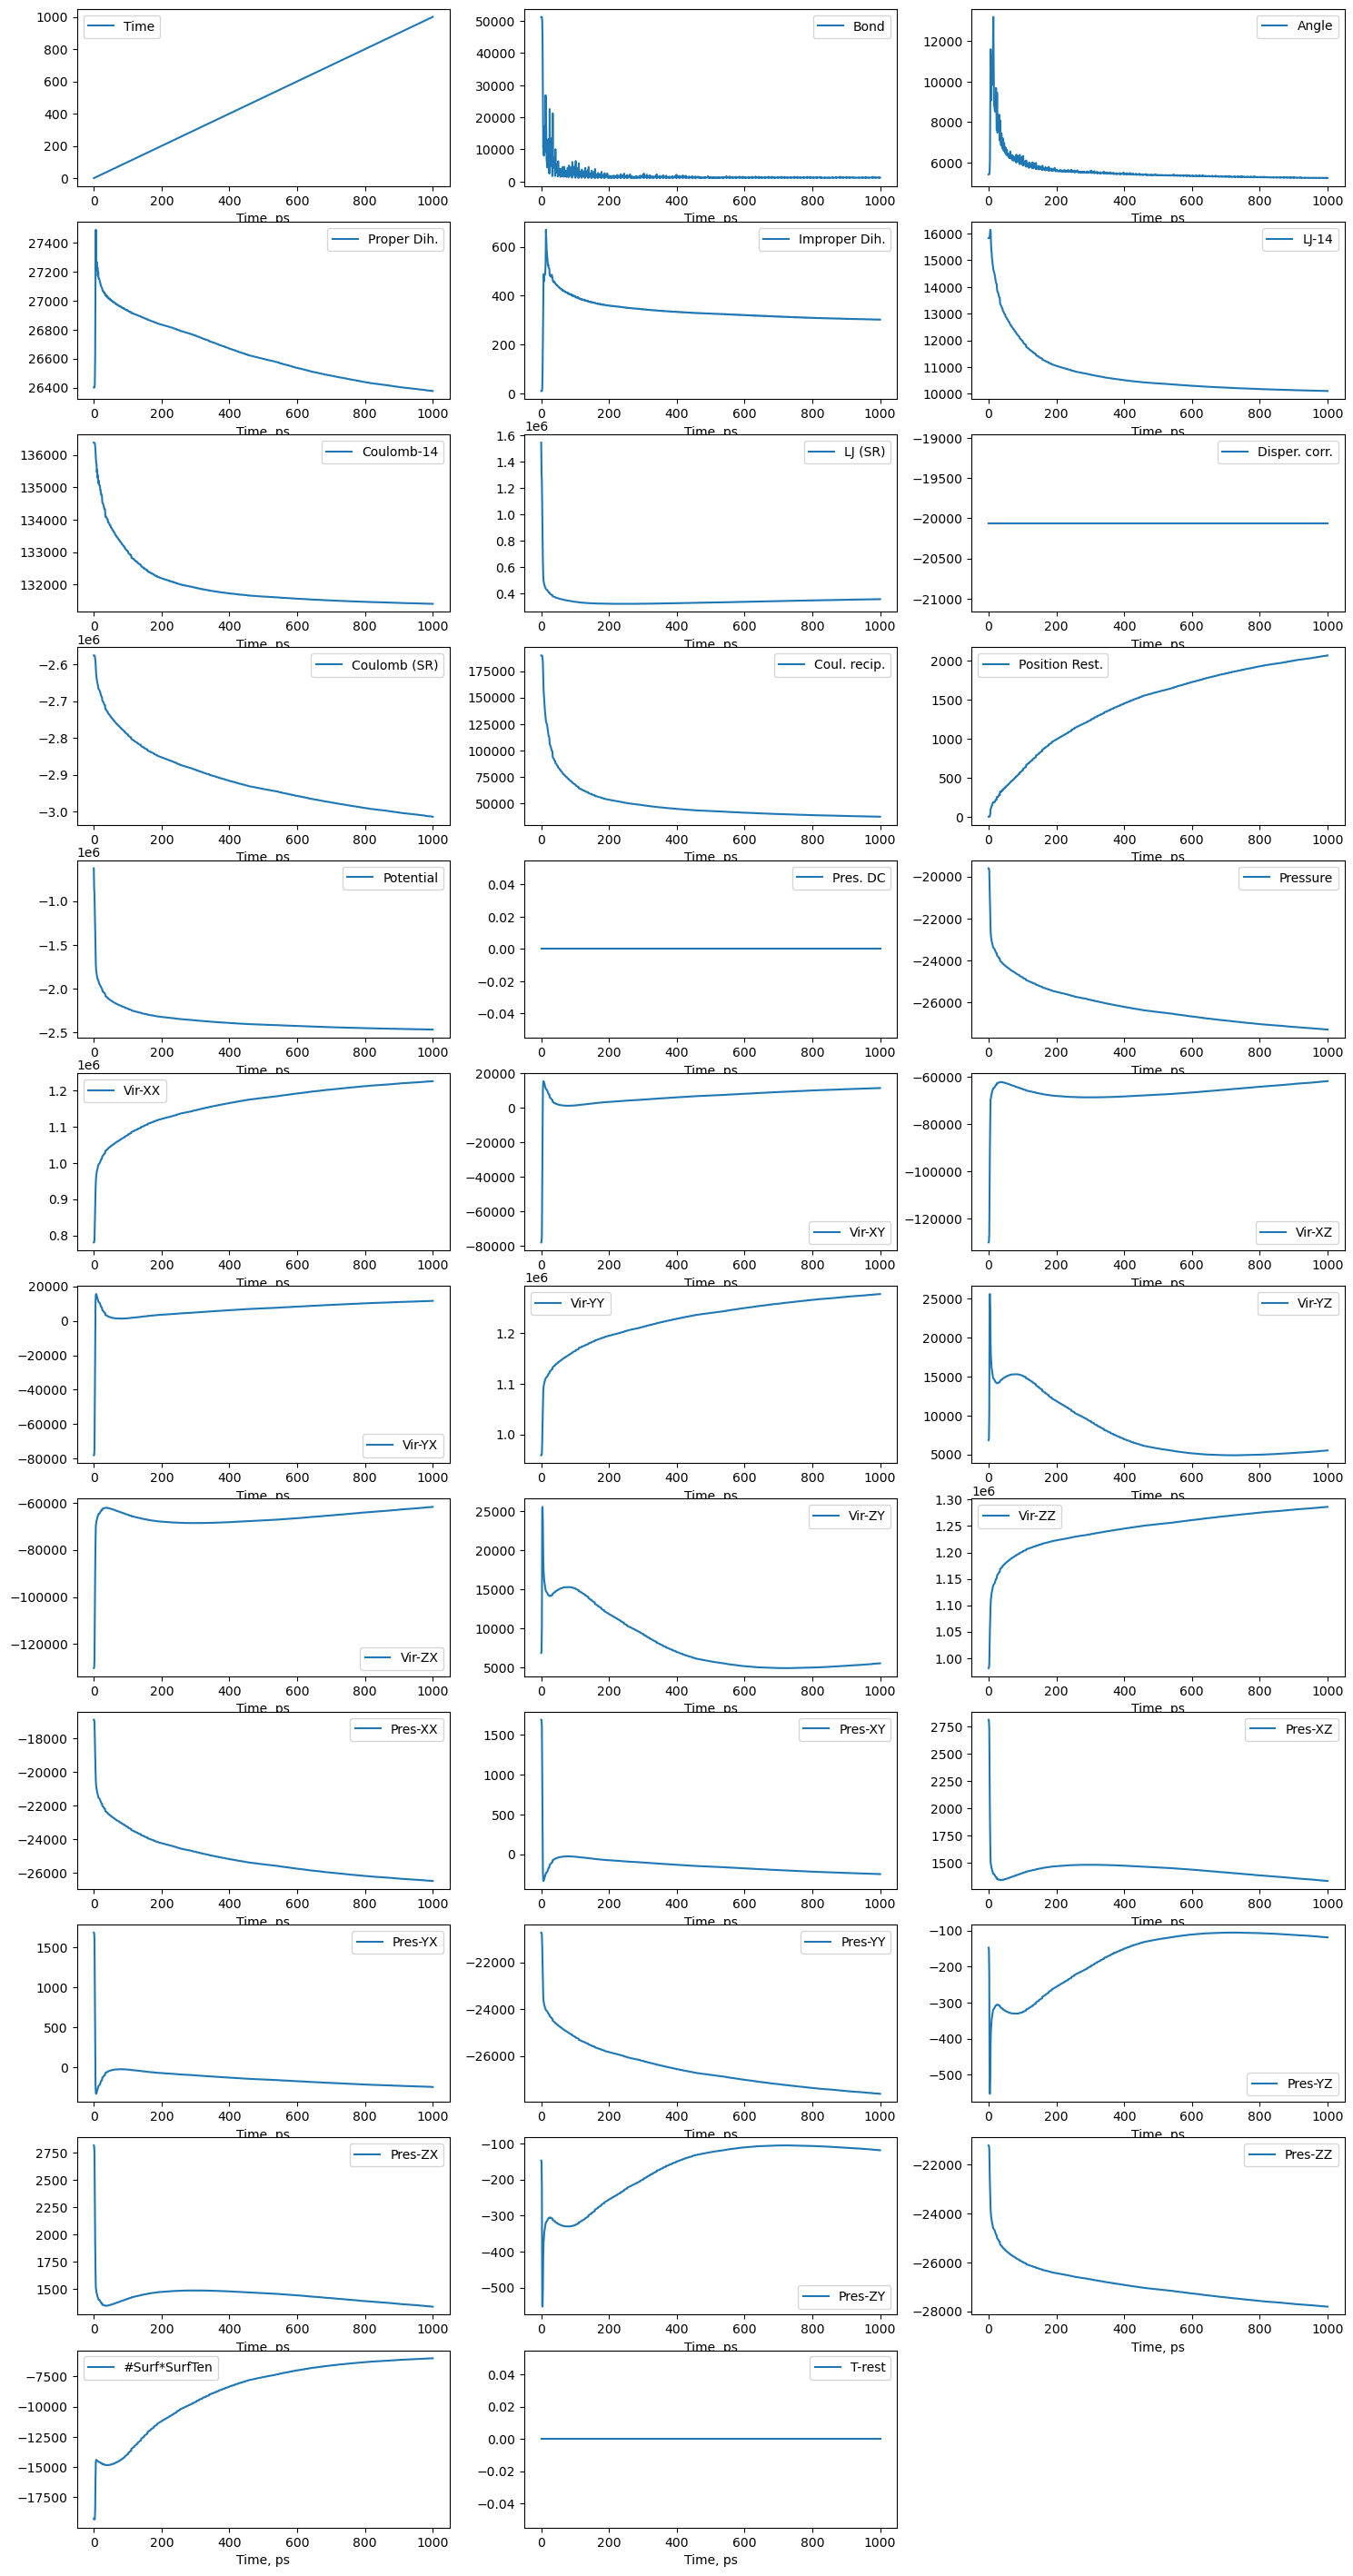

In [342]:
df = panedr.edr_to_df(f'{structure_id}_minim.edr', verbose=True)
num_of_keys = len(df.keys())
grid=[1+num_of_keys//3, 3]

plt.figure(figsize=(grid[1]*6, grid[0]*3))
plt.title('Mod')
for i, key in enumerate(df.keys(), 1):
    ax = plt.subplot(*grid, i)
    ax.plot(df[key][0:1000], label=key)
    ax.set_xlabel('Time, ps')
    ax.legend()    
plt.show()

## Equilibration 1

500 kJ/mol/Å<sup>2</sup> — limitation for heavy protein atoms. The `md` integrator is for molecular dynamics calculations.

Create a control file.

In [343]:
%%bash
cat << __EOF__ > equil1.mdp
;MDP-file for equilibraion 1: fist step 100 ps with 500 kJ/mol/A2 constraints on heavy atoms of protein and with timestep of 1 fs.

; VARIOUS PREPROCESSING OPTIONS
include                  = 
define                   = -DPOSRES ; will trigger the inclusion of posre.itp into your topology, used for implementing position restraints.
; here we assume that in posres.itp file all force constants have been changed to POSRES_FC

; RUN CONTROL PARAMETERS
integrator               = md
nsteps                   = 50000 ; 50000 steps
init-step                = 0 ; For exact run continuation or redoing part of a run
simulation-part          = 1 ; Part index is updated automatically on checkpointing (keeps files separate)
comm-mode                = Linear ; mode for center of mass motion removal

nstcomm                  = 100 ; number of steps for center of mass motion removal
comm-grps                =  System ; group(s) for center of mass motion removal default is the whole system;

dt                      = 0.001 ; this is only for MD

; OUTPUT CONTROL OPTIONS
; Output frequency for coords (x), velocities (v) and forces (f)
nstxout                  = 0
nstvout                  = 0
nstfout                  = 0
; Output frequency for energies to log file and energy file
nstlog                   = 1000
nstcalcenergy            = 100 ; why less???
nstenergy                = 1000

; Output frequency and precision for .xtc file
nstxout-compressed       = 1000 ; every 1 ps
compressed-x-precision   = 1000 

; This selects the subset of atoms for the compressed
; trajectory file. You can select multiple groups. By
; default, all atoms will be written.
compressed-x-grps        = 
; Selection of energy groups
energygrps               = 

; NEIGHBORSEARCHING PARAMETERS
; cut-off scheme (Verlet: particle based cut-offs, group: using charge groups)
cutoff-scheme            = Verlet
; nblist update frequency
nstlist                  = 10
; ns algorithm (simple or grid)
ns-type                  = Grid
; Periodic boundary conditions: xyz, no, xy
pbc                      = xyz
periodic-molecules       = no
; Allowed energy error due to the Verlet buffer in kJ/mol/ps per atom,
; a value of -1 means: use rlist
verlet-buffer-tolerance  = 0.005
; nblist cut-off        
rlist                    = 1.2 ; actually will be ignore and calculated from verlet-buffer-tolerance

; OPTIONS FOR ELECTROSTATICS AND VDW
; Method for doing electrostatics
coulombtype              = PME
coulomb-modifier         = None ; change from default Potential-shift-Verlet because Amber does not use shift.
rcoulomb-switch          = 0
rcoulomb                 = 0.8
; Relative dielectric constant for the medium and the reaction field
epsilon-r                = 1
epsilon-rf               = 0
; Method for doing Van der Waals
vdwtype                  = Cut-off
vdw-modifier             = None ; this matches Amber
; cut-off lengths       
rvdw_switch              = 0.8
rvdw                     = 0.8
; Apply long range dispersion corrections for Energy and Pressure
DispCorr                 = EnerPres ; This is default in AMBER, ??? AllEnerPres what is it?
; Extension of the potential lookup tables beyond the cut-off
table-extension          = 1
; Separate tables between energy group pairs
energygrp-table          = 
; Spacing for the PME/PPPM FFT grid
fourierspacing           = 0.12
; FFT grid size, when a value is 0 fourierspacing will be used
fourier-nx               = 0
fourier-ny               = 0
fourier-nz               = 0
; EWALD/PME/PPPM parameters
pme-order                = 4
ewald-rtol               = 1e-05
ewald-geometry           = 3d
epsilon-surface          = 0

; OPTIONS FOR BONDS    
constraints              = h-bonds ; this is a tweak for all-bonds to allow gromacs 2020 to calculate all non-bonded interactions on GPU
; Type of constraint algorithm
constraint_algorithm     = LINCS ; this is better than SHAKE so we retain it
; Do not constrain the start configuration
continuation             = no
; Highest order in the expansion of the constraint coupling matrix
lincs-order              = 4
; Number of iterations in the final step of LINCS. 1 is fine for
; normal simulations, but use 2 to conserve energy in NVE runs.
; For energy minimization with constraints it should be 4 to 8.
lincs-iter               = 8 ; in MD we will set this to 1
; Lincs will write a warning to the stderr if in one step a bond
; rotates over more degrees than
lincs-warnangle          = 30


; Below is only relevant for MD

; GENERATE VELOCITIES FOR STARTUP RUN
gen-vel                  = no
gen-temp                 = 300
gen-seed                 = -1


; OPTIONS FOR WEAK COUPLING ALGORITHMS
; Temperature coupling  
tcoupl                   = v-rescale
nsttcouple               = -1 ; the frequency of coupling the temperarure, -1 is automatic = nstlist for md integrator
; Groups to couple separately
tc-grps                  = System ; NOTE: Group name "System" is defined if you are NOT using an index file. But better to generate a default index file anyway.
; Time constant (ps) and reference temperature (K)
tau-t                    = 1 ; 1 ps as used in Amber paper, but we might need to research and use different for large scale dynamics!
ref-t                    = 300
; pressure coupling     
pcoupl                   = Berendsen
pcoupltype               = Isotropic
nstpcouple               = -1
; Time constant (ps), compressibility (1/bar) and reference P (bar)
tau-p                    = 1
compressibility          = 4.5e-5 ; for water
ref-p                    = 1 ; 1 bar
; Scaling of reference coordinates, No, All or COM
refcoord-scaling         = all ; The reference coordinates are scaled with the scaling matrix of the pressure coupling. 



__EOF__

Generated `.tpr` file.

In [344]:
%%bash -s "$structure_id"
structure_id=$1
gmx grompp -maxwarn 1 \
    -f equil1.mdp \
    -c ${structure_id}_minim.gro \
    -p ${structure_id}_topol.top \
    -o ${structure_id}_equil1.tpr \
    -v -r ${structure_id}_init_solv_ions.pdb \
    -po ${structure_id}_mdout_equil1.mdp

                      :-) GROMACS - gmx grompp, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

processing topology...
turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------



processing coordinates...
double-checking input for internal consistency...
Removing all charge groups because cutoff-scheme=Verlet
Reading position restraint coords from 3CAP_init_solv_ions.pdb
renumbering atomtypes...
converting bonded parameters...
initialising group options...
processing index file...
Making dummy/rest group for Acceleration containing 152139 elements
Making dummy/rest group for Freeze containing 152139 elements
Making dummy/rest group for Energy Mon. containing 152139 elements
Number of degrees of freedom in T-Coupling group System is 309804.00
Making dummy/rest group for User1 containing 152139 elements
Making dummy/rest group for User2 containing 152139 elements
Making dummy/rest group for Compressed X containing 152139 elements
Making dummy/rest group for Or. Res. Fit containing 152139 elements
Making dummy/rest group for QMMM containing 152139 elements
T-Coupling       has 1 element(s): System
Energy Mon.      has 1 element(s): rest
Acceleration     has 1 elem

Analysing residue names:
There are:   652    Protein residues
There are: 47156      Water residues
There are:   343        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.812 nm, buffer size 0.012 nm
Set rlist, assuming 4x4 atom pair-list, to 0.800 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 200x72x72, spacing 0.120 0.111 0.111
This run will generate roughly 49 Mb of data


Run molecular dinamics.

In [ ]:
%%bash -s "$structure_id"
structure_id=$1
gmx mdrun -ntomp 2 -ntmpi 1 -deffnm ${structure_id}_equil1

                      :-) GROMACS - gmx mdrun, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

Look at results.

In [26]:
MD = mda.Universe(f'{structure_id}_equil1.tpr', f'{structure_id}_equil1.xtc')
sel = MD.select_atoms('all')
a = nv.show_mdanalysis(sel,gui=False)
a.add_representation(selection='ion', repr_type='spacefill', opacity=0.9)
a.add_representation(selection='water', repr_type='spacefill', opacity=0.1)
a

NGLWidget(max_frame=50)

Video:

In [4]:
Video('figs/fig6.mp4')

Using `panedr`, I plotted the change in paraneters during equilibration 1. At this step, the potential energy and temperature increase.

51it [00:00, 13619.60it/s]


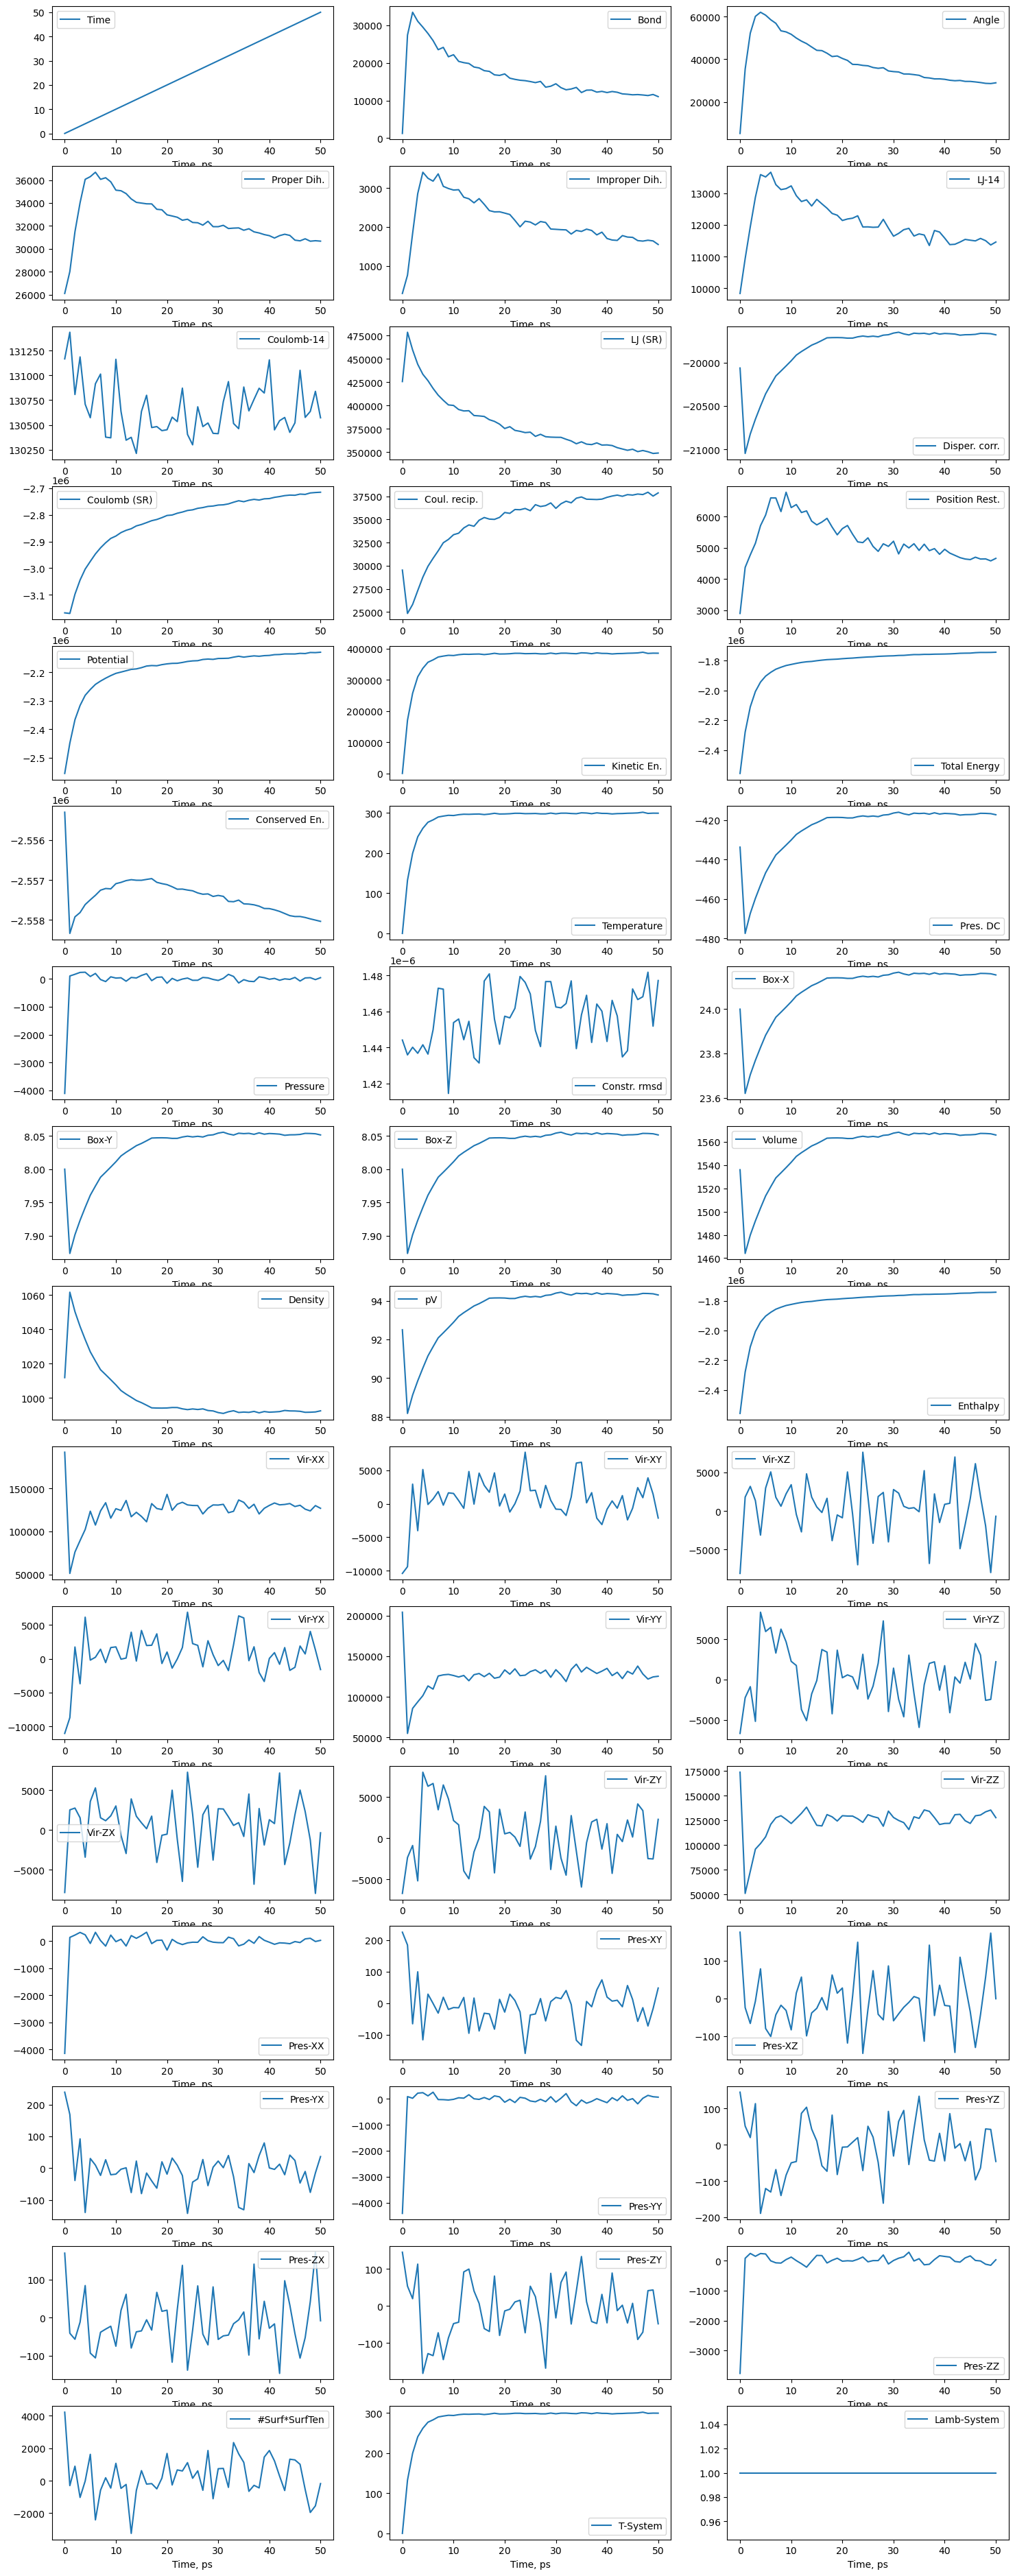

In [354]:
df = panedr.edr_to_df(f'{structure_id}_equil1.edr', verbose=True)
num_of_keys = len(df.keys())
grid = [1+num_of_keys//3,3]

plt.figure(figsize=(grid[1]*6,grid[0]*3))
plt.title('Mod')
for i, key in enumerate(df.keys(), 1):
    ax = plt.subplot(*grid, i)
    ax.plot(df[key][0:1000], label=key)
    ax.set_xlabel('Time, ps')
    ax.legend()    
plt.show()

## Equilibration 2

There are no restrictions on the movement of atoms (no `define` directive). The `md` integrator is for molecular dynamics calculations.

Create a control file.

In [356]:
%%bash
cat << __EOF__ > equil2.mdp
;MDP-file for equilibraion 2

; VARIOUS PREPROCESSING OPTIONS
include                  = 


; RUN CONTROL PARAMETERS
integrator               = md
nsteps                   = 50000 ; 50000 steps
init-step                = 0 ; For exact run continuation or redoing part of a run
simulation-part          = 1 ; Part index is updated automatically on checkpointing (keeps files separate)
comm-mode                = Linear ; mode for center of mass motion removal

nstcomm                  = 100 ; number of steps for center of mass motion removal
comm-grps                =  System ; group(s) for center of mass motion removal default is the whole system;

dt                      = 0.002 ; this is only for MD

; ENERGY MINIMIZATION OPTIONS
; Force tolerance and initial step-size
emtol                    = 100.0
emstep                   = 0.01

; OUTPUT CONTROL OPTIONS
; Output frequency for coords (x), velocities (v) and forces (f)
nstxout                  = 0
nstvout                  = 0
nstfout                  = 0
; Output frequency for energies to log file and energy file
nstlog                   = 1000
nstcalcenergy            = 100 ; why less???
nstenergy                = 1000

; Output frequency and precision for .xtc file
nstxout-compressed       = 5000 ; every 10 ps
compressed-x-precision   = 1000 

; This selects the subset of atoms for the compressed
; trajectory file. You can select multiple groups. By
; default, all atoms will be written.
compressed-x-grps        = 
; Selection of energy groups
energygrps               = 

; NEIGHBORSEARCHING PARAMETERS
; cut-off scheme (Verlet: particle based cut-offs, group: using charge groups)
cutoff-scheme            = Verlet
; nblist update frequency
nstlist                  = 10
; ns algorithm (simple or grid)
ns-type                  = Grid
; Periodic boundary conditions: xyz, no, xy
pbc                      = xyz
periodic-molecules       = no
; Allowed energy error due to the Verlet buffer in kJ/mol/ps per atom,
; a value of -1 means: use rlist
verlet-buffer-tolerance  = 0.005
; nblist cut-off        
rlist                    = 1.2 ; actually will be ignore and calculated from verlet-buffer-tolerance

; OPTIONS FOR ELECTROSTATICS AND VDW
; Method for doing electrostatics
coulombtype              = PME
coulomb-modifier         = None ; change from default Potential-shift-Verlet because Amber does not use shift.
rcoulomb-switch          = 0
rcoulomb                 = 0.8
; Relative dielectric constant for the medium and the reaction field
epsilon-r                = 1
epsilon-rf               = 0
; Method for doing Van der Waals
vdwtype                  = Cut-off
vdw-modifier             = None ; this matches Amber
; cut-off lengths       
rvdw_switch              = 0.8
rvdw                     = 0.8
; Apply long range dispersion corrections for Energy and Pressure
DispCorr                 = EnerPres ; This is default in AMBER, ??? AllEnerPres what is it?
; Extension of the potential lookup tables beyond the cut-off
table-extension          = 1
; Separate tables between energy group pairs
energygrp-table          = 
; Spacing for the PME/PPPM FFT grid
fourierspacing           = 0.12
; FFT grid size, when a value is 0 fourierspacing will be used
fourier-nx               = 0
fourier-ny               = 0
fourier-nz               = 0
; EWALD/PME/PPPM parameters
pme-order                = 4
ewald-rtol               = 1e-05
ewald-geometry           = 3d
epsilon-surface          = 0

; OPTIONS FOR BONDS    
constraints              = h-bonds ; this is a tweak fro all-bonds to allow gromacs 2020 to calculate all non-bonded interactions on GPU
; Type of constraint algorithm
constraint_algorithm     = LINCS ; this is better than SHAKE so we retain it
; Do not constrain the start configuration
continuation             = no
; Highest order in the expansion of the constraint coupling matrix
lincs-order              = 4
; Number of iterations in the final step of LINCS. 1 is fine for
; normal simulations, but use 2 to conserve energy in NVE runs.
; For energy minimization with constraints it should be 4 to 8.
lincs-iter               = 8 ; in MD we will set this to 1
; Lincs will write a warning to the stderr if in one step a bond
; rotates over more degrees than
lincs-warnangle          = 30


; Below is only relevant for MD

; GENERATE VELOCITIES FOR STARTUP RUN
gen-vel                  = no
gen-temp                 = 300
gen-seed                 = -1


; OPTIONS FOR WEAK COUPLING ALGORITHMS
; Temperature coupling  
tcoupl                   = v-rescale
nsttcouple               = -1 ; the frequency of coupling the temperarure, -1 is automatic = nstlist for md integrator
; Groups to couple separately
tc-grps                  = System ; NOTE: Group name "System" is defined if you are NOT using an index file. But better to generate a default index file anyway.
; Time constant (ps) and reference temperature (K)
tau-t                    = 1 ; 1 ps as used in Amber paper, but we might need to research and use different for large scale dynamics!
ref-t                    = 300
; pressure coupling     
pcoupl                   = Parrinello-Rahman
pcoupltype               = Isotropic
nstpcouple               = -1
; Time constant (ps), compressibility (1/bar) and reference P (bar)
tau-p                    = 1
compressibility          = 4.5e-5 ; for water
ref-p                    = 1 ; 1 bar
; Scaling of reference coordinates, No, All or COM
refcoord-scaling         = all ; The reference coordinates are scaled with the scaling matrix of the pressure coupling. 


__EOF__

Generated the `.tpr` file.

In [358]:
%%bash -s "$structure_id"
structure_id=$1
gmx grompp -maxwarn 1 \
    -f equil2.mdp \
    -c ${structure_id}_equil1.gro \
    -p ${structure_id}_topol.top \
    -o ${structure_id}_equil2.tpr \
    -v -r ${structure_id}_init_solv_ions.pdb \
    -po ${structure_id}_mdout_equil2.mdp

                      :-) GROMACS - gmx grompp, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

processing topology...
turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------



processing coordinates...
double-checking input for internal consistency...
Removing all charge groups because cutoff-scheme=Verlet
renumbering atomtypes...
converting bonded parameters...
initialising group options...
processing index file...
Making dummy/rest group for Acceleration containing 152139 elements
Making dummy/rest group for Freeze containing 152139 elements
Making dummy/rest group for Energy Mon. containing 152139 elements
Number of degrees of freedom in T-Coupling group System is 309804.00
Making dummy/rest group for User1 containing 152139 elements
Making dummy/rest group for User2 containing 152139 elements
Making dummy/rest group for Compressed X containing 152139 elements
Making dummy/rest group for Or. Res. Fit containing 152139 elements
Making dummy/rest group for QMMM containing 152139 elements
T-Coupling       has 1 element(s): System
Energy Mon.      has 1 element(s): rest
Acceleration     has 1 element(s): rest
Freeze           has 1 element(s): rest
User1     

Analysing residue names:
There are:   652    Protein residues
There are: 47156      Water residues
There are:   343        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.835 nm, buffer size 0.035 nm
Set rlist, assuming 4x4 atom pair-list, to 0.800 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 208x72x72, spacing 0.116 0.112 0.112
This run will generate roughly 20 Mb of data


Run molecular dynamics.

In [360]:
%%bash -s "$structure_id"
structure_id=$1
gmx mdrun -ntomp 2 -ntmpi 1 -deffnm ${structure_id}_equil2

                      :-) GROMACS - gmx mdrun, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

Look at results.

In [27]:
MD = mda.Universe(f'{structure_id}_equil2.tpr', f'{structure_id}_equil2.xtc')
sel = MD.select_atoms('all')
a = nv.show_mdanalysis(sel,gui=False)
a.add_representation(selection='ion', repr_type='spacefill', opacity=0.9)
a.add_representation(selection='water', repr_type='spacefill', opacity=0.1)
a

NGLWidget(max_frame=10)

Video:

In [5]:
Video('figs/fig7.mp4')

Using `panedr`, I plotted the change in parameters during equilibration 2.

51it [00:00, 8094.35it/s]


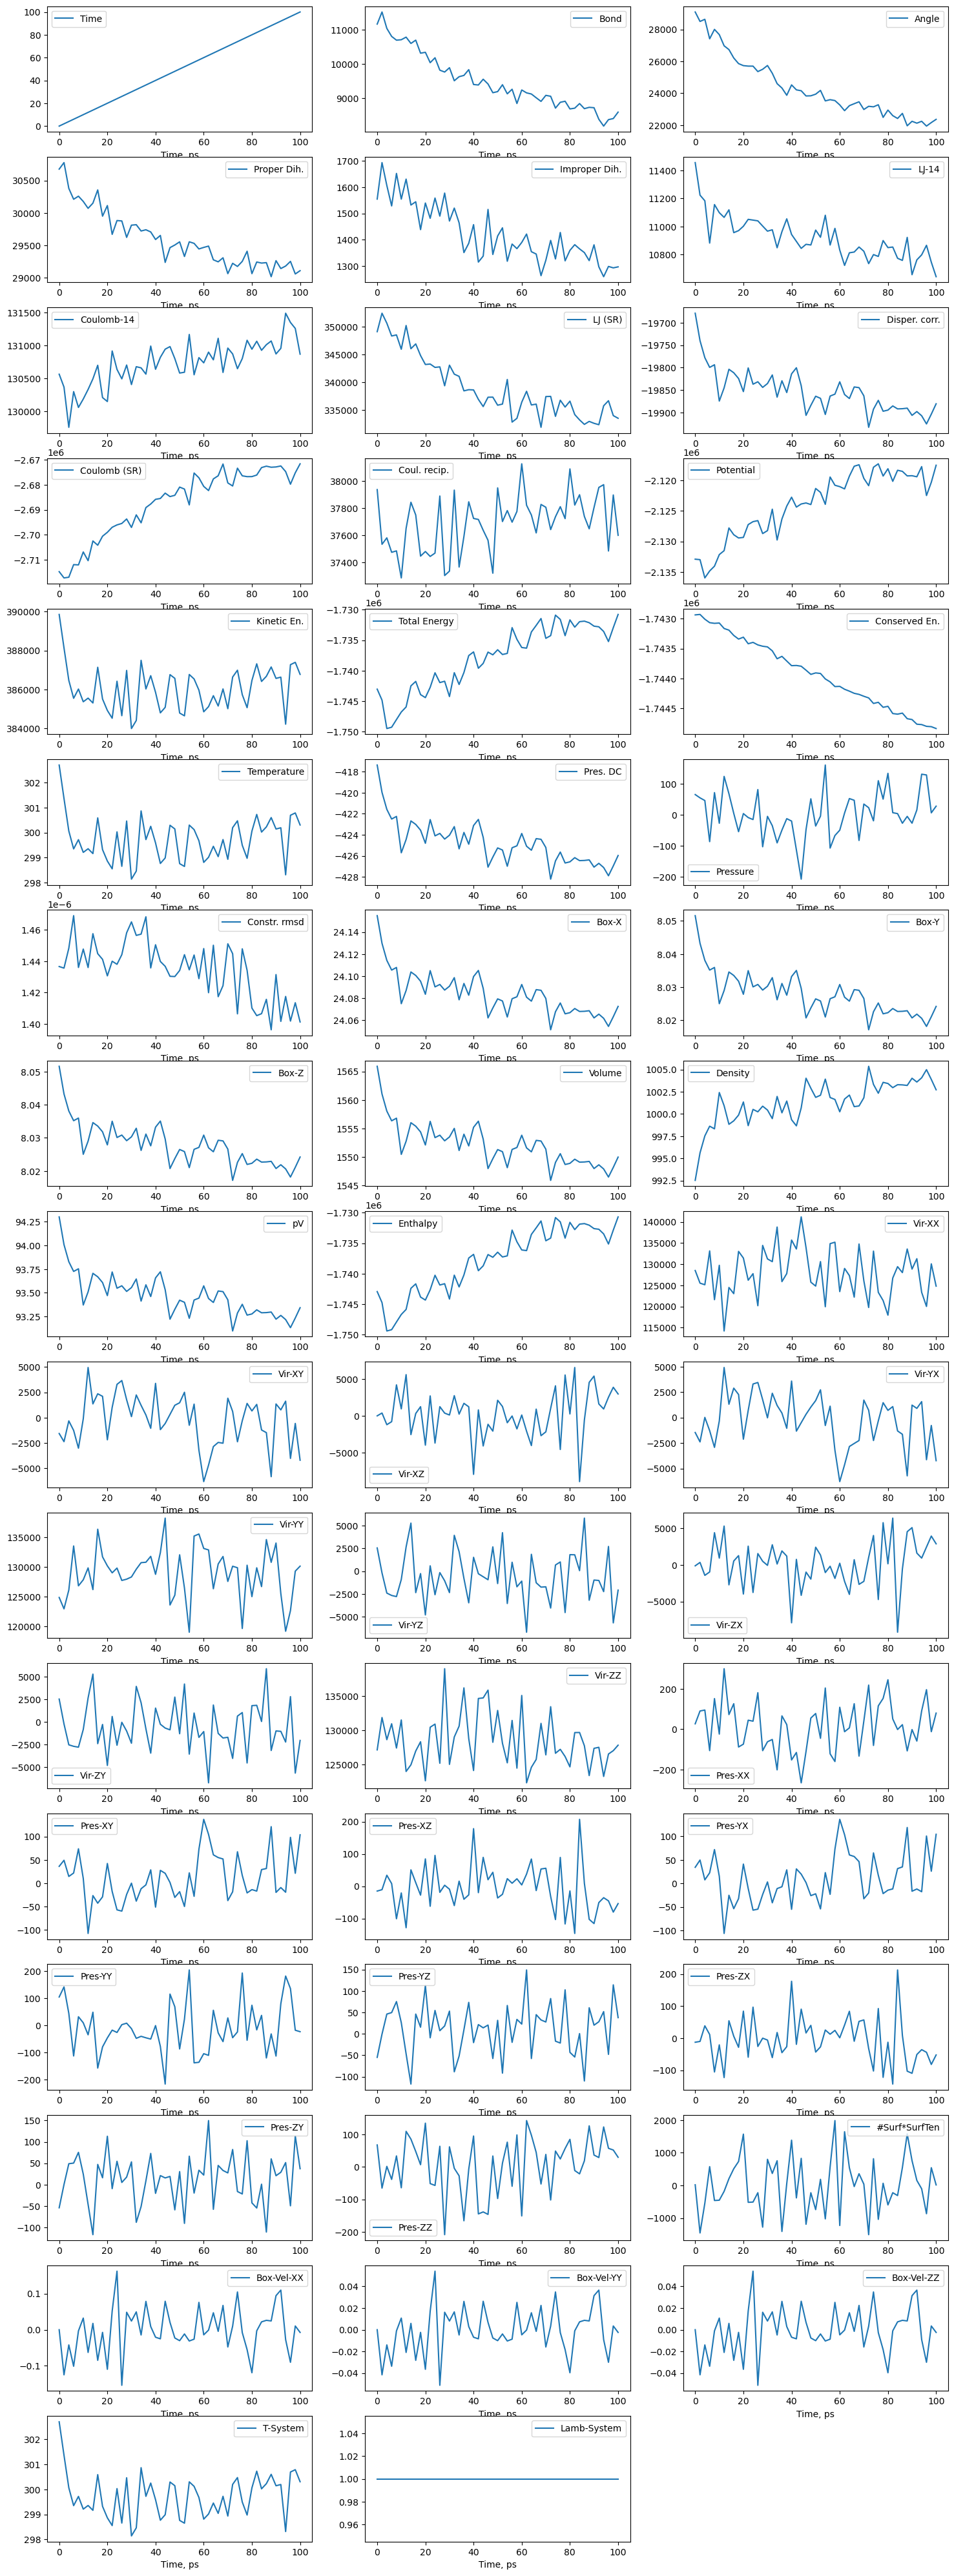

In [361]:
df = panedr.edr_to_df(f'{structure_id}_equil2.edr', verbose=True)
num_of_keys = len(df.keys())
grid = [1+num_of_keys//3,3]

plt.figure(figsize=(grid[1]*6,grid[0]*3))
plt.title('Mod')
for i, key in enumerate(df.keys(), 1):
    ax = plt.subplot(*grid, i)
    ax.plot(df[key][0:1000], label=key)
    ax.set_xlabel('Time, ps')
    ax.legend()    
plt.show()

I drew the distributions of all parameters.

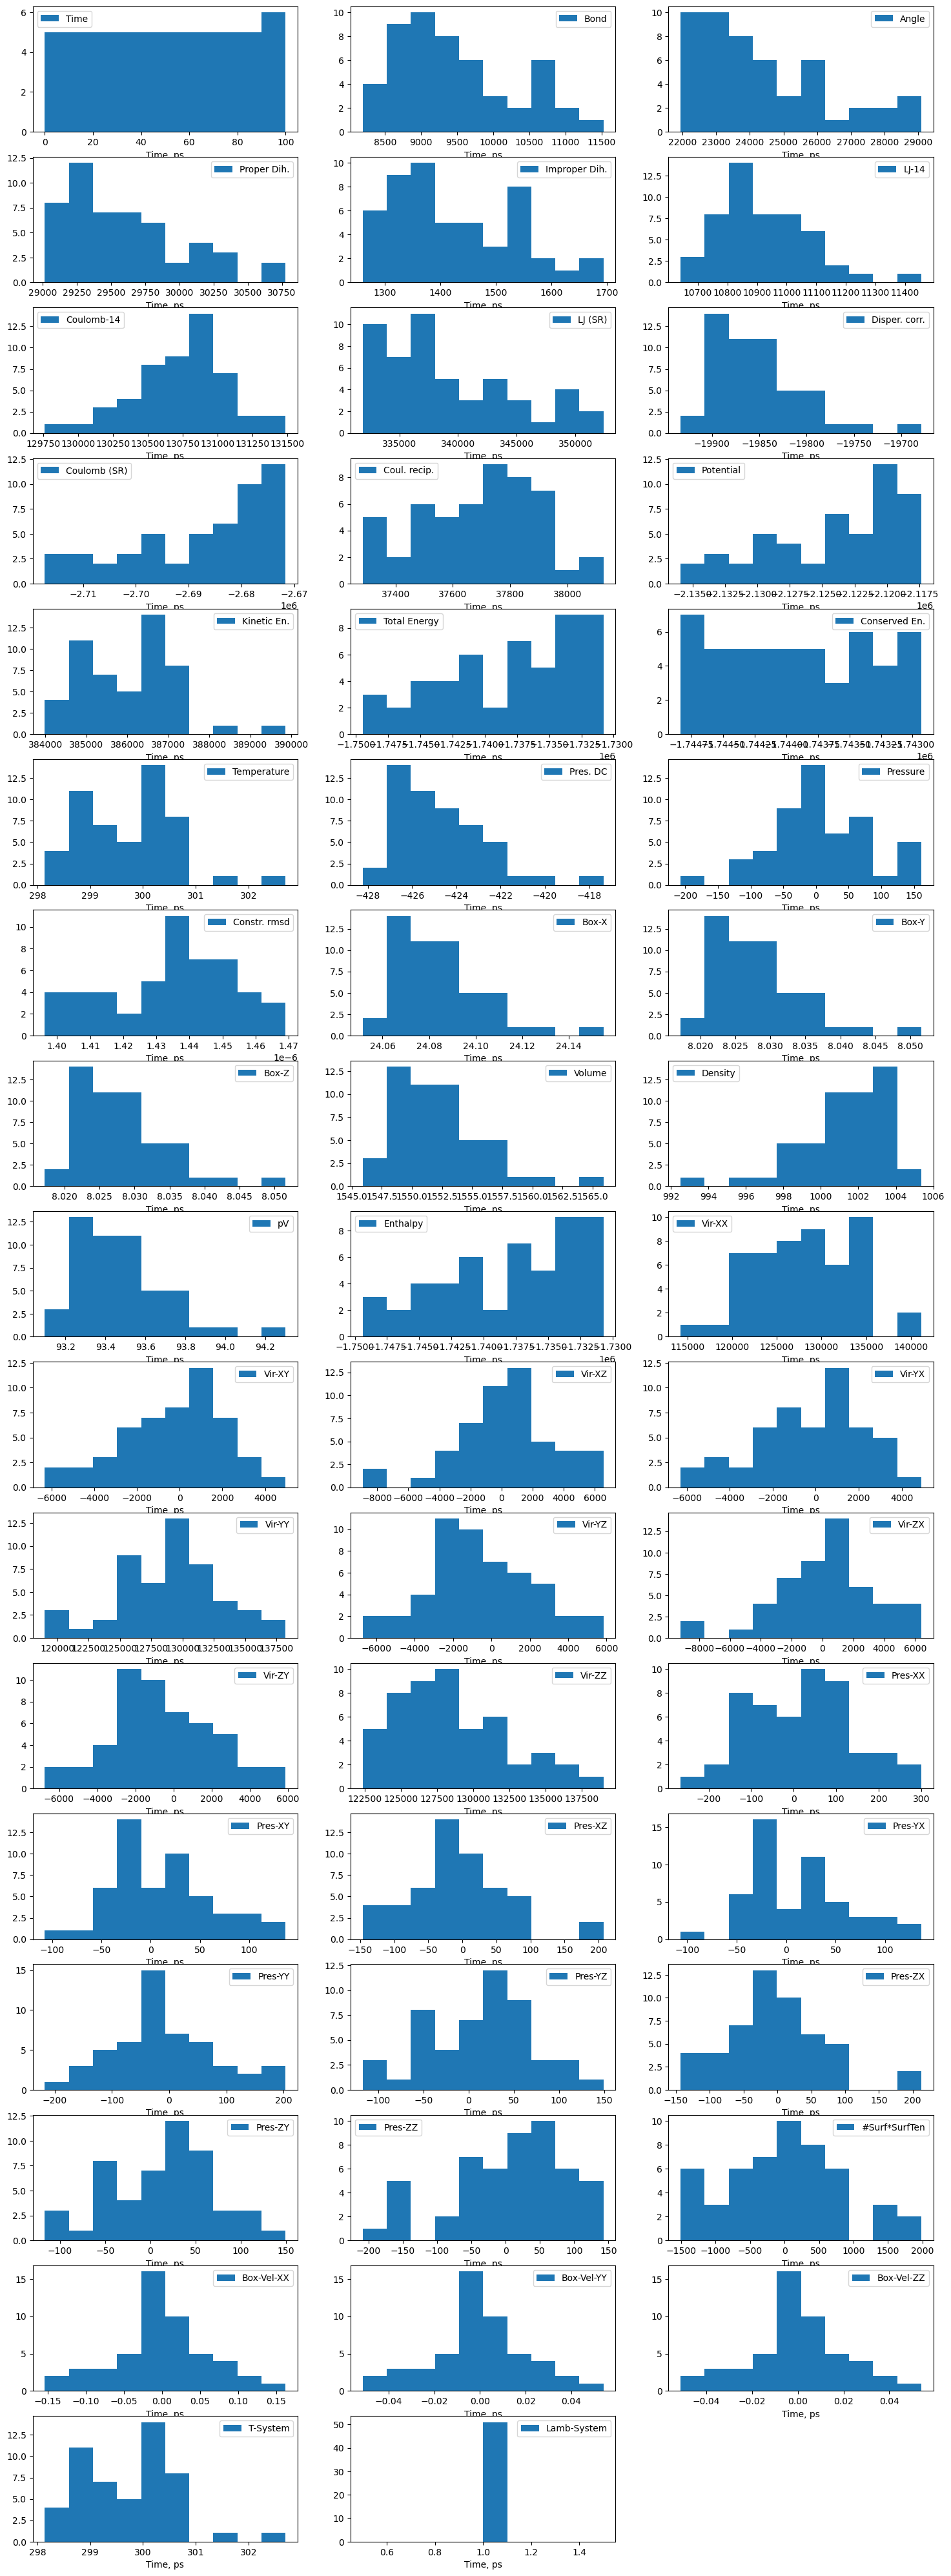

In [362]:
plt.figure(figsize=(grid[1]*6, grid[0]*3))
plt.title('Mod')
for i, key in enumerate(df.keys(),1):
    ax = plt.subplot(*grid, i)
    ax.hist(df[key][0:1000], label=key)
    ax.set_xlabel('Time, ps')
    ax.legend()    
plt.show()

## Production

Create a control file.

In [370]:
%%bash
cat << __EOF__ > prod.mdp
;MDP-file production run: 10 000 ns.
; this protocol now generates velocities this is useful for generating parallel runs with different random seeds
; random seeds are selected randomly by grompp here

; VARIOUS PREPROCESSING OPTIONS
include                  = 
define                   = ; NO RESTRAINTS DEFINED HERE


; RUN CONTROL PARAMETERS
integrator               = md ; Steepest descent integrator
nsteps                   = 50000 ; 50000 = 1 nanosecond
init-step                = 0 ; For exact run continuation or redoing part of a run
simulation-part          = 1 ; Part index is updated automatically on checkpointing (keeps files separate)
comm-mode                = Linear ; mode for center of mass motion removal
'
nstcomm                  = 100 ; number of steps for center of mass motion removal
comm-grps                =  System ; group(s) for center of mass motion removal default is the whole system;

dt                      = 0.002 ; this is only for MD

; ENERGY MINIMIZATION OPTIONS
; Force tolerance and initial step-size
emtol                    = 100.0
emstep                   = 0.01

; OUTPUT CONTROL OPTIONS
; Output frequency for coords (x), velocities (v) and forces (f)
nstxout                  = 0
nstvout                  = 0
nstfout                  = 0
; Output frequency for energies to log file and energy file
nstlog                   = 1000
nstcalcenergy            = 100 ; why less -> looks like this is needed for thermostats/barostats
nstenergy                = 1000

; Output frequency and precision for .xtc file
nstxout-compressed       = 5000 ; every 10 ps 
compressed-x-precision   = 1000 

; This selects the subset of atoms for the compressed
; trajectory file. You can select multiple groups. By
; default, all atoms will be written.
compressed-x-grps        = 
; Selection of energy groups
energygrps               = 

; NEIGHBORSEARCHING PARAMETERS
; cut-off scheme (Verlet: particle based cut-offs, group: using charge groups)
cutoff-scheme            = Verlet
; nblist update frequency
nstlist                  = 10
; ns algorithm (simple or grid)
ns-type                  = Grid
; Periodic boundary conditions: xyz, no, xy
pbc                      = xyz
periodic-molecules       = no
; Allowed energy error due to the Verlet buffer in kJ/mol/ps per atom,
; a value of -1 means: use rlist
verlet-buffer-tolerance  = 0.005
; nblist cut-off        
rlist                    = 1.2 ; actually will be ignore and calculated from verlet-buffer-tolerance

; OPTIONS FOR ELECTROSTATICS AND VDW
; Method for doing electrostatics
coulombtype              = PME
coulomb-modifier         = None ; change from default Potential-shift-Verlet because Amber does not use shift.
rcoulomb-switch          = 0
rcoulomb                 = 0.8
; Relative dielectric constant for the medium and the reaction field
epsilon-r                = 1
epsilon-rf               = 0
; Method for doing Van der Waals
vdwtype                  = Cut-off
vdw-modifier             = None ; this matches Amber
; cut-off lengths       
rvdw_switch              = 0.8
rvdw                     = 0.8
; Apply long range dispersion corrections for Energy and Pressure
DispCorr                 = EnerPres ; This is default in AMBER, ??? AllEnerPres what is it?
; Extension of the potential lookup tables beyond the cut-off
table-extension          = 1
; Separate tables between energy group pairs
energygrp-table          = 
; Spacing for the PME/PPPM FFT grid
fourierspacing           = 0.12
; FFT grid size, when a value is 0 fourierspacing will be used
fourier-nx               = 0
fourier-ny               = 0
fourier-nz               = 0
; EWALD/PME/PPPM parameters
pme-order                = 4
ewald-rtol               = 1e-05
ewald-geometry           = 3d
epsilon-surface          = 0

; OPTIONS FOR BONDS    
constraints              = h-bonds ; this is a tweak fro all-bonds to allow gromacs 2020 to calculate all non-bonded interactions on GPU
; Type of constraint algorithm
constraint_algorithm     = LINCS ; this is better than SHAKE so we retain it
; Do not constrain the start configuration
continuation             = no
; Highest order in the expansion of the constraint coupling matrix
lincs-order              = 4
; Number of iterations in the final step of LINCS. 1 is fine for
; normal simulations, but use 2 to conserve energy in NVE runs.
; For energy minimization with constraints it should be 4 to 8.
lincs-iter               = 1 ; in MD we will set this to 1
; Lincs will write a warning to the stderr if in one step a bond
; rotates over more degrees than
lincs-warnangle          = 30


; Below is only relevant for MD

; GENERATE VELOCITIES FOR STARTUP RUN
gen-vel                  = yes
gen-temp                 = 300
gen-seed                 = -1


; OPTIONS FOR WEAK COUPLING ALGORITHMS
; Temperature coupling  
tcoupl                   = v-rescale
nsttcouple               = -1 ; the frequency of coupling the temperarure, -1 is automatic = nstlist for md integrator
; Groups to couple separately
tc-grps                  = System ; NOTE: Group name "System" is defined if you are NOT using an index file. But better to generate a default index file anyway.
; Time constant (ps) and reference temperature (K)
tau-t                    = 1 ; 1 ps as used in Amber paper, but we might need to research and use different for large scale dynamics!
ref-t                    = 300
; pressure coupling     
pcoupl                   = Parrinello-Rahman
pcoupltype               = Isotropic
nstpcouple               = -1
; Time constant (ps), compressibility (1/bar) and reference P (bar)
tau-p                    = 1
compressibility          = 4.5e-5 ; for water
ref-p                    = 1 ; 1 bar
; Scaling of reference coordinates, No, All or COM
refcoord-scaling         = all ; The reference coordinates are scaled with the scaling matrix of the pressure coupling. 
; ??? check if com is better?




__EOF__

Generate the `.tpr`.

In [378]:
%%bash -s "$structure_id"
structure_id=$1
gmx grompp -maxwarn 2 \
    -f prod.mdp \
    -c ${structure_id}_equil2.gro \
    -p ${structure_id}_topol.top \
    -o ${structure_id}_prod.tpr \
    -v -r ${structure_id}_init_solv_ions.pdb \
    -po ${structure_id}_mdout_prod.mdp

                      :-) GROMACS - gmx grompp, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

processing topology...
turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------



processing coordinates...
double-checking input for internal consistency...
Setting gen_seed to 592121061
Velocities were taken from a Maxwell distribution at 300 K
Removing all charge groups because cutoff-scheme=Verlet
renumbering atomtypes...
converting bonded parameters...
initialising group options...
processing index file...
Making dummy/rest group for Acceleration containing 152139 elements
Making dummy/rest group for Freeze containing 152139 elements
Making dummy/rest group for Energy Mon. containing 152139 elements
Number of degrees of freedom in T-Coupling group System is 309804.00
Making dummy/rest group for User1 containing 152139 elements
Making dummy/rest group for User2 containing 152139 elements
Making dummy/rest group for Compressed X containing 152139 elements
Making dummy/rest group for Or. Res. Fit containing 152139 elements
Making dummy/rest group for QMMM containing 152139 elements
T-Coupling       has 1 element(s): System
Energy Mon.      has 1 element(s): rest
A

Analysing residue names:
There are:   652    Protein residues
There are: 47156      Water residues
There are:   343        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.835 nm, buffer size 0.035 nm
Set rlist, assuming 4x4 atom pair-list, to 0.800 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 208x72x72, spacing 0.116 0.111 0.111
This run will generate roughly 20 Mb of data


Run molecular dynamics.

In [379]:
%%bash -s "$structure_id"
structure_id=$1
gmx mdrun -ntomp 2 -ntmpi 1 -deffnm ${structure_id}_prod

                      :-) GROMACS - gmx mdrun, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

Look at results.

In [28]:
MD = mda.Universe(f'{structure_id}_prod.tpr', f'{structure_id}_prod.xtc')
sel = MD.select_atoms('all')
a = nv.show_mdanalysis(sel, gui=False)
a.add_representation(selection='ion', repr_type='spacefill', opacity=0.9)
a.add_representation(selection='water', repr_type='spacefill', opacity=0.1)
a

NGLWidget(max_frame=10)

Video:

In [6]:
Video('figs/fig8.mp4')

The protein appeared to have some long sticks. Looks like a minor breakdown. Otherwise, it looks good. The system did not explode.